In [1]:
! pip install pytorch-lightning -q
! pip list | grep torch
! nvidia-smi

pytorch-lightning            1.6.4               
torch                        1.10.0+cu102        
torchmetrics                 0.9.1               
torchsampler                 0.1.2               
torchvision                  0.11.1+cu102        
Wed Jun 15 01:39:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 495.46       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default 

In [2]:
!ls

Kaggle_Plant_Pathology_with_Lightning_ipynb의_사본.ipynb  icevision.ipynb
Untitled.ipynb						  icevision_install.sh
annotation.ipynb					  images
annotations						  k_cross_CNN.pt
classifier_data						  train.csv
cross_validation-Copy1.ipynb				  train_images
cross_validation.ipynb					  train_images.zip
getting_started_object_detection.ipynb


In [3]:
path_to_zip_file = 'train_images.zip'
directory_to_extract_to = 'train_images/'

import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [7]:
import random
import torch
def seed_everything(seed=7):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']= str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False

In [175]:
%matplotlib inline

import os
import json
import pandas as pd
from pprint import pprint

base_path = 'train_images/'
path_csv = os.path.join(base_path, 'train.csv')
train_data = pd.read_csv(path_csv)
#test_data=pd.read_csv(os.path.join(base_path, 'test_csv.csv'))

In [5]:
import numpy as np

train_data['nb_classes'] = [len(lbs.split(" ")) for lbs in train_data['labels']]
lb_hist = dict(zip(range(10), np.bincount(train_data['nb_classes'])))
print(lb_hist)

{0: 0, 1: 17277, 2: 1155, 3: 200}


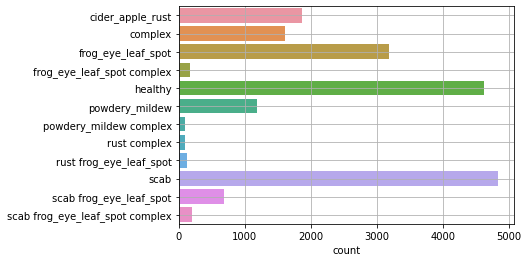

In [176]:
import itertools
import seaborn as sns

labels_all = list(train_data['labels'])
ax = sns.countplot(y=sorted(labels_all), orient='v')
ax.grid()

In [8]:
labels_unique=sorted(labels_all)
{lb: i for i, lb in enumerate(labels_unique)}

{'cider_apple_rust': 1859,
 'complex': 4010,
 'frog_eye_leaf_spot': 8362,
 'healthy': 12986,
 'powdery_mildew': 14257,
 'rust': 14474,
 'scab': 20186}

In [181]:
data= pd.read_csv(os.path.join(base_path, 'data.csv'))
data = data.sample(frac=1).reset_index(drop=True)
data.head(10)

,Unnamed: 0,image,labels,nb_classes
0,14329,e48e829a29b57b17.jpg,frog_eye_leaf_spot,1
1,1423,8abc65c20f33e4da.jpg,rust,1
2,9182,c0bc431f5396b0f5.jpg,frog_eye_leaf_spot,1
3,3876,a049d60f8b88f17f.jpg,cider_apple_rust,1
4,14471,e58655bd36640c5b.jpg,rust,1
5,14799,e89794cb81e0f4ce.jpg,scab,1
6,17786,fc098ba6654fb489.jpg,frog_eye_leaf_spot,1
7,12795,d959c39b468588fa.jpg,frog_eye_leaf_spot,1
8,2001,905e6078e5d1ef0d.jpg,scab,1
9,17385,f90784e094a4fcf6.jpg,healthy,1


In [10]:
print(data['labels'].value_counts())

scab                  5712
healthy               4624
frog_eye_leaf_spot    4352
rust                  2077
cider_apple_rust      1860
powdery_mildew        1271
Name: labels, dtype: int64


**< imbalance data를 해결하는 방법 >**

1. oversampling 
장점 : under-sampling보다 성능이 뛰어나다. 
단점 : minor class를 판별시 과적합 될 가능성이 있다.

2. undersampling
장점 :  모델이 빨리 돌아간다.
단점 : 과적합

3. SMOTE : 주변에 있는 데이터셋의 특징과 유사하게 데이터를 생성한다.
장점 : 데이터 손실을 하지 않으면서 과적합을 피할 수 있다.
단점 : 고차원 데이터에 효율적이지 않다.

우리는 고차원 데이터를 다루고 있기때문에 oversampling을 쓸 것이다.

**< Pytorch 에서는 어떻게 ? >** 

파이토치에서 sampler 옵션을 사용하면 데이터 크래스와 상호 작용하고 이 클래스에서 샘플링 하는 방법을 알려준다.
다른 클래스의 가중치를 사용하여 sampler 클래스 객체를 생성하는 방식이다.

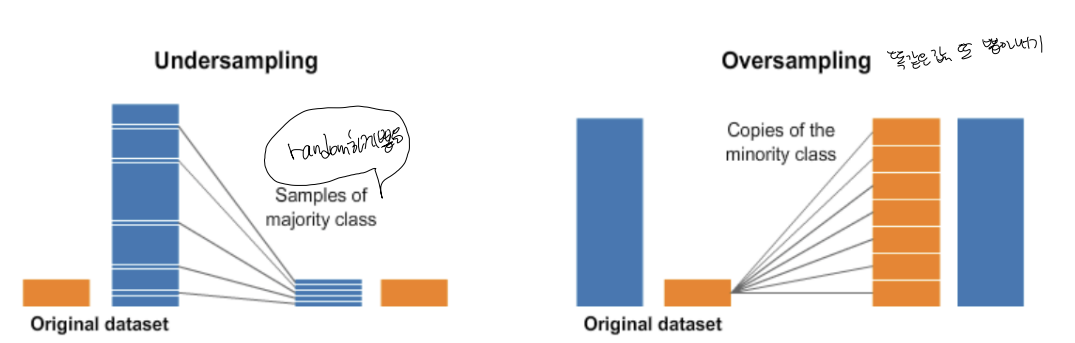

**< 주의할 점! >**

반드시 cross-validation을 한 후에 데이터를 증강시킨다.
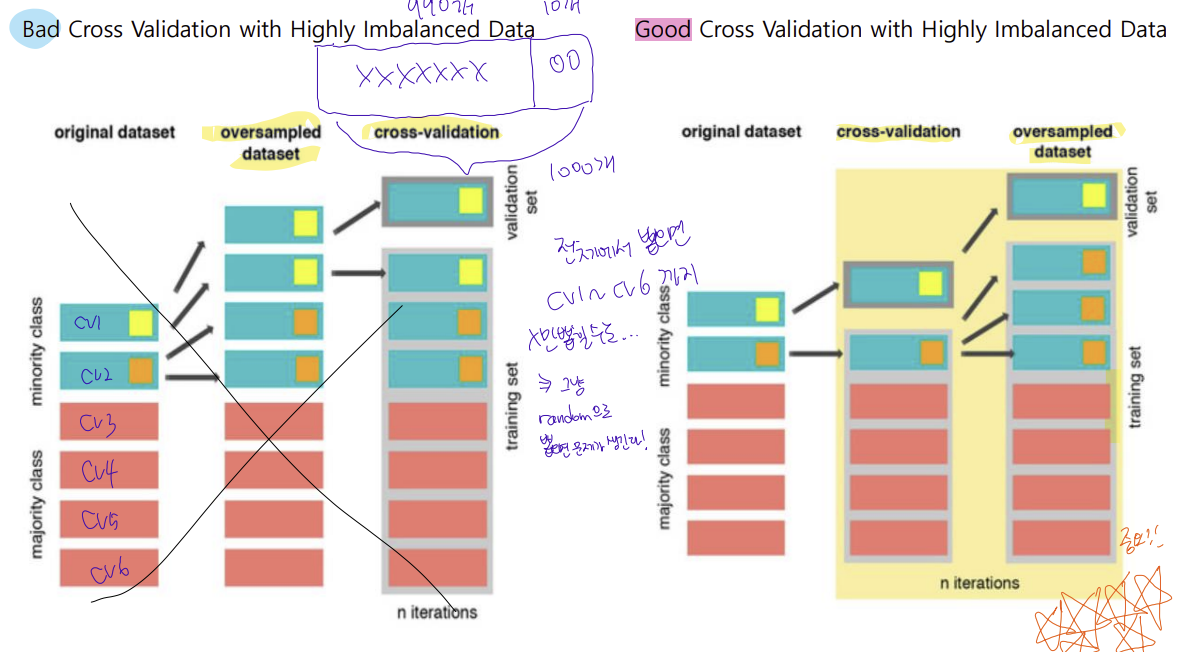

In [10]:
# labels_unique = set(labels_all)
# print(f"unique labels: {labels_unique}")
# train_data['labels_sorted'] = [" ".join(sorted(lbs.split(" "))) for lbs in train_data['labels']]

# labels_combine = {}
# for comb in train_data['labels_sorted']:
#     labels_combine[comb] = labels_combine.get(comb, 0) + 1

# show_counts = '\n'.join(sorted(f'\t{k}: {v}' for k, v in labels_combine.items()))
# print(f"unique combinations: \n" + show_counts)
# print(f"total: {sum(labels_combine.values())}")

(-0.5, 959.5, 640.5, -0.5)

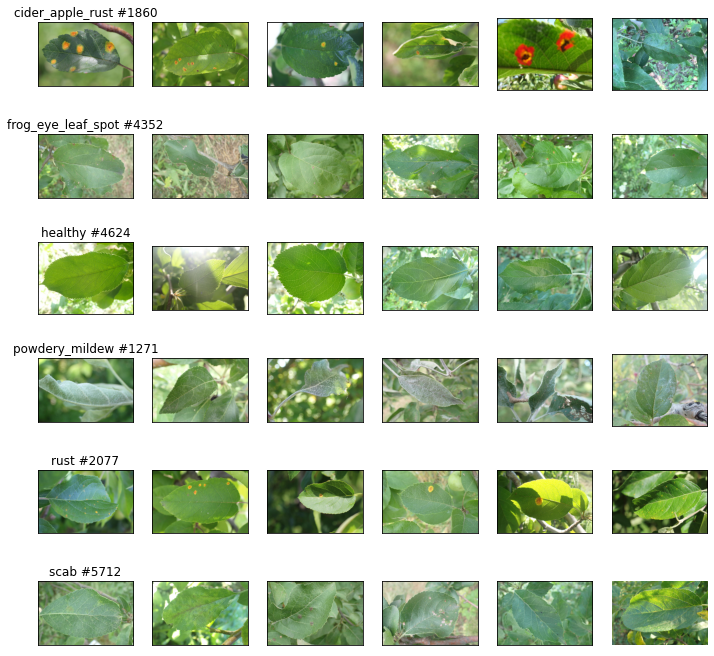

In [11]:
import matplotlib.pyplot as plt

nb_samples = 6
n, m = len(np.unique(data['labels'])), nb_samples,
fig, axarr = plt.subplots(nrows=n, ncols=m, figsize=(m * 2, n * 2))
for ilb, (lb, df_) in enumerate(data.groupby('labels')):
    img_names = list(df_['image'])
    for i in range(m):
        img_name = img_names[i]
        img = plt.imread(os.path.join(base_path, f"train_images/{img_name}"))
        axarr[ilb, i].imshow(img)
        if i == 0:
            axarr[ilb, i].set_title(f"{lb} #{len(df_)}")
        axarr[ilb, i].set_xticks([])
        axarr[ilb, i].set_yticks([])
plt.axis('off')

In [160]:
def edge_and_cut(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    emb_img[row_min-10:row_min+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_max-10:row_max+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_min:row_max, col_min-10:col_min+10] = [255, 0, 0]
    emb_img[row_min:row_max, col_max-10:col_max+10] = [255, 0, 0]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(new_img, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

데이터셋 준비!

0
[ 3806  3808  3810 ... 19893 19894 19895]
[   0    1    2 ... 4262 4280 4283]
1
[    0     1     2 ... 19893 19894 19895]
[3806 3808 3810 ... 8247 8255 8268]
2
[    0     1     2 ... 19893 19894 19895]
[ 7859  7861  7863 ... 12221 12226 12236]
3
[    0     1     2 ... 19893 19894 19895]
[11755 11756 11758 ... 16039 16046 16047]
4
[    0     1     2 ... 16039 16046 16047]
[15782 15795 15809 ... 19893 19894 19895]


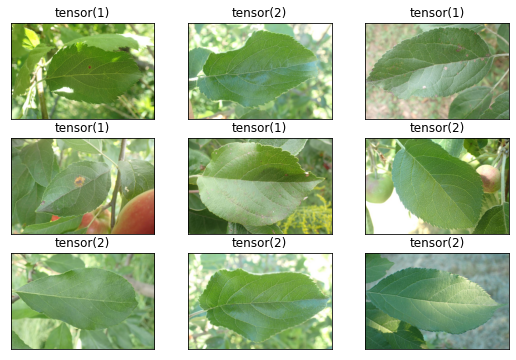

In [12]:
from sklearn.model_selection import StratifiedKFold
n_iter=0
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(data['image'], data['labels']):
            print(n_iter)
            n_iter+=1
            print(train_index)
            print(test_index)
import os
import torch
from PIL import Image
from torch.utils.data import Dataset

class PlantPathologyDataset(Dataset):
    def __init__(
        self,
        path_csv: str = os.path.join(base_path, 'data.csv'),
        path_img_dir: str = os.path.join(base_path, 'train_images'),
        transforms = None,
        mode: str = 'train',
        split: float = 0.8,
    ):
        self.path_img_dir = path_img_dir
        self.transforms = transforms
        self.mode = mode

        self.data = pd.read_csv(path_csv)
        labels_all = list(itertools.chain(*[lbs.split(" ") for lbs in self.data['labels']]))
        self.labels_unique = sorted(set(labels_all))
        self.labels_lut = {lb: i for i, lb in enumerate(self.labels_unique)}
        self.num_classes = len(self.labels_unique)

        # split dataset
        self.data = self.data.sample(frac=1).reset_index(drop=True)
        self.data = self.data.iloc[train_index] if mode == 'train' else self.data.iloc[test_index]
        self.img_names = list(self.data['image'])
        self.labels = list(self.data['labels'])

    def to_one_hot(self, labels: str) -> tuple:
        one_hot = [0] * len(self.labels_unique)
        for lb in labels.split(" "):
            one_hot[self.labels_lut[lb]] = 1
        return tuple(one_hot)

    def __getitem__(self, idx: int) -> tuple:
        img_path = os.path.join(self.path_img_dir, self.img_names[idx])
        assert os.path.isfile(img_path)
        label = self.labels[idx]
        img = plt.imread(img_path)

        # augmentation
        if self.transforms:
            img = self.transforms(Image.fromarray(img))
        label = self.to_one_hot(label)
        label=np.argmax(label).reshape(-1,1)
        return img, torch.tensor(label[0][0])

    def __len__(self) -> int:
        return len(self.data)

# ==============================
# ==============================

dataset = PlantPathologyDataset()

# quick view
fig = plt.figure(figsize=(9, 6))
for i in range(9):
    img, lb = dataset[i]
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(lb)

In [13]:
train_data = data.iloc[train_index,]
test_data=data.iloc[test_index,]

In [14]:
from torchvision import transforms as T
TRAIN_TRANSFORM = T.Compose([
    T.Resize(512),
    T.RandomPerspective(),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # T.Normalize([0.431, 0.498,  0.313], [0.237, 0.239, 0.227]),  # custom
])

VALID_TRANSFORM = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # T.Normalize([0.431, 0.498,  0.313], [0.237, 0.239, 0.227]),  # custom
])

training dataset: 15917
test dataset: 3979
6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch labels: 349
image size: torch.Size([3, 224, 224])
<class 'torch.Tensor'>


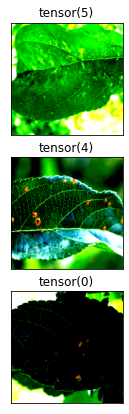

In [136]:
import multiprocessing as mproc
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class PlantPathologyDM(pl.LightningDataModule):
    dataset_cls = PlantPathologyDataset

    def __init__(
        self,
        path_csv: str = os.path.join(base_path, 'data.csv'),
        path_img_dir: str = os.path.join(base_path, 'train_images'),
        batch_size: int = 128,
        num_workers: int = None,
    ):
        super().__init__()
        self.path_csv = path_csv
        self.path_img_dir = path_img_dir
        self.batch_size = batch_size
        self.num_workers = num_workers if num_workers is not None else mproc.cpu_count()
        self.train_dataset = None
        self.test_dataset = None

    def prepare_data(self):
        pass

    @property
    def num_classes(self) -> int:
        assert self.train_dataset and self.test_dataset
        return max(self.train_dataset.num_classes, self.test_dataset.num_classes)

    def setup(self, stage=None):
        self.train_dataset = self.dataset_cls(self.path_csv, self.path_img_dir, mode='train', transforms=TRAIN_TRANSFORM)
        print(f"training dataset: {len(self.train_dataset)}")
        self.test_dataset = self.dataset_cls(self.path_csv, self.path_img_dir, mode='test', transforms=VALID_TRANSFORM)
        print(f"test dataset: {len(self.test_dataset)}")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )


    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

# ==============================
# ==============================

dm = PlantPathologyDM()
dm.setup()
print(dm.num_classes)

# quick view
fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.test_dataloader():
    print(f'batch labels: {torch.sum(lbs, axis=0)}')
    print(f'image size: {imgs[0].shape}')
    print(type(imgs))
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


##CNN Model

In [16]:
def create_model(pretrained=True):
    model = torchvision.models.resnet50(pretrained=pretrained).to(device)
    
    for param in model.layer1.parameters():
        param.requires_grad = False
        
    for param in model.layer2.parameters():
        param.requires_grad = False  
        
    for param in model.layer3.parameters():
        param.requires_grad = False 
    
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(
            in_features=model.fc.in_features,
            out_features=6
        ),
        torch.nn.Sigmoid()
    ).to(device)
    
    return model


In [17]:
num_epochs=10
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [30]:
import torch.nn as nn
foldperf={}
from torch.utils.data import SubsetRandomSampler
nSamples = [5712,4624,4352,2077,1860,1271]
normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
normedWeights = torch.FloatTensor(normedWeights).to(device)
criterion = nn.CrossEntropyLoss(normedWeights)
for fold, (train_idx,val_idx) in enumerate(skf.split(train_data['image'], train_data['labels'])):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(PlantPathologyDataset(mode='train', transforms=TRAIN_TRANSFORM), batch_size=2, sampler=train_sampler)
    test_loader = DataLoader(PlantPathologyDataset(mode='train', transforms=VALID_TRANSFORM), batch_size=2, sampler=test_sampler)
    
    model = create_model(pretrained=True).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

torch.save(model,'k_cross_CNN.pt')   

Fold 1
Epoch:1/10 AVG Training Loss:1.448 AVG Test Loss:1.256 AVG Training Acc 53.77 % AVG Test Acc 70.04 %
Epoch:2/10 AVG Training Loss:1.339 AVG Test Loss:1.219 AVG Training Acc 64.67 % AVG Test Acc 73.96 %
Epoch:3/10 AVG Training Loss:1.306 AVG Test Loss:1.229 AVG Training Acc 67.51 % AVG Test Acc 76.07 %
Epoch:4/10 AVG Training Loss:1.289 AVG Test Loss:1.193 AVG Training Acc 68.49 % AVG Test Acc 78.61 %
Epoch:5/10 AVG Training Loss:1.276 AVG Test Loss:1.202 AVG Training Acc 70.24 % AVG Test Acc 77.01 %
Epoch:6/10 AVG Training Loss:1.269 AVG Test Loss:1.201 AVG Training Acc 70.82 % AVG Test Acc 76.19 %
Epoch:7/10 AVG Training Loss:1.263 AVG Test Loss:1.199 AVG Training Acc 71.54 % AVG Test Acc 75.91 %
Epoch:8/10 AVG Training Loss:1.256 AVG Test Loss:1.192 AVG Training Acc 72.01 % AVG Test Acc 76.88 %
Epoch:9/10 AVG Training Loss:1.258 AVG Test Loss:1.201 AVG Training Acc 71.51 % AVG Test Acc 75.57 %
Epoch:10/10 AVG Training Loss:1.253 AVG Test Loss:1.195 AVG Training Acc 72.77 % AVG

In [182]:
labels_all=list(itertools.chain(*[lbs.split(" ") for lbs in data['labels']]))
labels_unique = sorted(set(labels_all))
labels_lut = {lb: i for i, lb in enumerate(labels_unique)}
num_classes = len(labels_unique)
categories=[k for k,v in labels_lut.items()]
labels_lut

{'cider_apple_rust': 0,
 'frog_eye_leaf_spot': 1,
 'healthy': 2,
 'powdery_mildew': 3,
 'rust': 4,
 'scab': 5}

In [19]:
labels_lut.items()

dict_items([('cider_apple_rust', 0), ('frog_eye_leaf_spot', 1), ('healthy', 2), ('powdery_mildew', 3), ('rust', 4), ('scab', 5)])

In [32]:
model2=torch.load('k_cross_CNN.pt')
model2.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [68]:
def count_frequency(my_list):
    
    count = {}
    
    for item in my_list:
        count[item] = count.get(item, 0) + 1
        
    return count

In [177]:
preds = []
dm.batch_size = 256
total_batch = int(3979/dm.batch_size)
for i in range(total_batch):
    for imgs, names in dm.test_dataloader():
            with torch.no_grad():
                imgs=imgs.cuda()
                encode = model2(imgs)
                #print(encode)
            #print(np.round(encode.cpu().numpy(), decimals=2))
            for be, name in zip(encode,names ):#여기서 be는 encode 원소들 즉, 예측결과
                count= count_frequency(np.round(be.cpu().numpy(), decimals=2))
                if 1.0 in count.keys() and count[1.0]==2 :
                        temp=np.argpartition(be.cpu().detach().numpy(), -2)[-2:]
                        lbs=int(name.numpy()) if name.numpy() in temp else temp[0]
                else:   lbs=np.argmax(be.cpu().detach().numpy())
                preds.append(dict(labels=int(name.numpy()), predict=lbs))
            break

df_preds = pd.DataFrame(preds)
print(df_preds.head())

   labels  predict
0       5        5
1       4        4
2       0        0
3       5        5
4       4        4


In [178]:
data = {'y_Actual':    list(df_preds['labels'].values),
        'y_Predicted': list(df_preds['predict'].values),
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
print (df)

      y_Actual  y_Predicted
0            5            5
1            4            4
2            0            0
3            5            5
4            4            4
...        ...          ...
3835         2            2
3836         2            2
3837         2            2
3838         5            5
3839         0            0

[3840 rows x 2 columns]


In [179]:
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted    0    1    2    3    4    5
Actual                                 
0          270    0   30    0   45    0
1            0  660    0   15   30   75
2            0    0  960   30    0    0
3            0   15    0  285    0    0
4            0   75   15    0  285    0
5            0   45   90    0    0  915


In [185]:
from sklearn.metrics import classification_report
print(classification_report(df['y_Predicted'],df['y_Actual']))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       270
           1       0.85      0.83      0.84       795
           2       0.97      0.88      0.92      1095
           3       0.95      0.86      0.90       330
           4       0.76      0.79      0.78       360
           5       0.87      0.92      0.90       990

    accuracy                           0.88      3840
   macro avg       0.86      0.88      0.87      3840
weighted avg       0.88      0.88      0.88      3840

